<a href="https://colab.research.google.com/github/joeldmott/inventory_project/blob/main/inventory_restocking_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing packages to read in data from Kaggle host site
import json
import os
from pathlib import Path
from google.colab import userdata

# api key for importing Kaggle and downloading the datasets
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

# api key for the json object below
api_key = userdata.get('API_KEY')

# using pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opening file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [2]:
import kaggle
! kaggle datasets download joelmott/liquor-inventory-dataset

Dataset URL: https://www.kaggle.com/datasets/joelmott/liquor-inventory-dataset
License(s): MIT
 85% 57.0M/67.1M [00:00<00:00, 98.3MB/s]
100% 67.1M/67.1M [00:00<00:00, 103MB/s] 


In [3]:
!unzip liquor-inventory-dataset.zip

Archive:  liquor-inventory-dataset.zip
  inflating: liquor sales dataset.csv  


In [4]:
import pandas as pd
df = pd.read_csv('/content/liquor sales dataset.csv')
df.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,...,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,S24127700024,2/19/2015,3678,"Smoke Shop, The",1918 SE 14TH ST,DES MOINES,50320,POINT (-93.597011 41.570844),77.0,Polk,...,41783,Uv Blue Raspberry Vodka Mini,6,500,4.89,7.34,2,14.68,1.0,0.26
1,S15066200002,10/10/2013,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14TH ST,DES MOINES,50320,POINT (-93.596754 41.554101),77.0,Polk,...,904969,Sabe Premiom Sake Double Barrel,6,750,14.99,22.49,6,134.94,4.5,1.19
2,S19323500030,6/3/2014,2607,Hy-Vee Wine and Spirits / Shenandoah,520 SO FREMONT,SHENANDOAH,51601,POINT (-95.385111 40.761736),73.0,Page,...,45277,Paramount White Rum,12,1000,4.34,6.51,12,78.12,12.0,3.17
3,S23334500013,1/6/2015,4810,Kum & Go #518 / Ankeny,3603 NE OTTERVIEW CIRCLE,ANKENY,50021,POINT (-93.572458 41.760989),77.0,Polk,...,43121,Bacardi Superior Rum Mini,12,500,5.54,8.31,1,8.31,0.5,0.13
4,S09742200010,12/27/2012,4025,Karam Kaur Khasriya Llc,702 13TH ST,BELLE PLAINE,52208,POINT (-92.277759 41.897052),6.0,Benton,...,11298,Crown Royal Canadian Whisky,6,1750,31.00,46.49,2,92.98,3.5,0.92


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Invoice/Item Number    1048575 non-null  object 
 1   Date                   1048575 non-null  object 
 2   Store Number           1048575 non-null  int64  
 3   Store Name             1048575 non-null  object 
 4   Address                1047448 non-null  object 
 5   City                   1047448 non-null  object 
 6   Zip Code               1047439 non-null  object 
 7   Store Location         954963 non-null   object 
 8   County Number          1045978 non-null  float64
 9   County                 1045978 non-null  object 
 10  Category               1048341 non-null  float64
 11  Category Name          1048053 non-null  object 
 12  Vendor Number          1048575 non-null  int64  
 13  Vendor Name            1048575 non-null  object 
 14  Item Number       

In [6]:
#Where are these stores?
#df.sample(50)
#Ah, they're all in (and from all around) Iowa.

In [7]:
#What's the date range?
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()

(Timestamp('2012-01-03 00:00:00'), Timestamp('2018-10-08 00:00:00'))

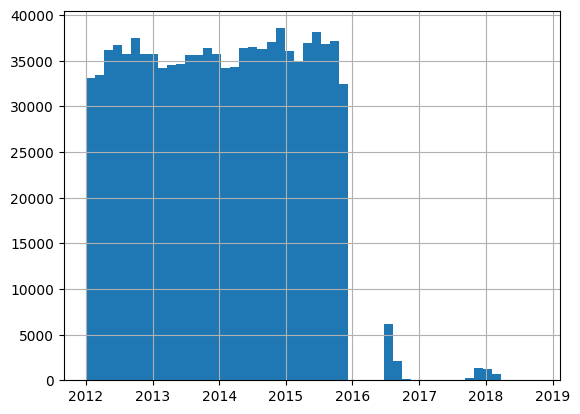

In [8]:
df['Date'].hist(bins=50);

In [9]:
df['Date']

0         2015-02-19
1         2013-10-10
2         2014-06-03
3         2015-01-06
4         2012-12-27
             ...    
1048570   2014-01-13
1048571   2013-09-09
1048572   2015-04-07
1048573   2012-11-29
1048574   2012-08-13
Name: Date, Length: 1048575, dtype: datetime64[ns]

Obviously, we'll drop the random few date entries from 2016-2018, but the real tragedy here is the missing data from the very end of 2015. I don't think it's a good idea to try and impute and time-series data here, so we'll have to drop everything from 2015 on. However, this still gives us three complete years of data, which isn't bad.

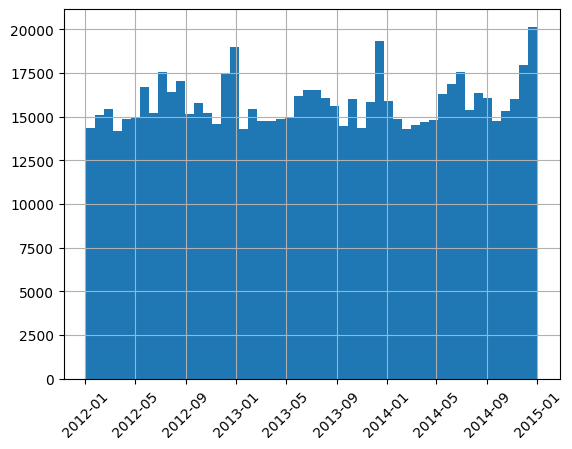

In [10]:
trimmed_df = df[~(df['Date'] > '2015-01-03 00:00:00')]
trimmed_df['Date'].hist(xrot=45, bins=50);

With our time-series data sorted out, let's examine the amount of stores we have.

In [11]:
#How many stores?
unique_stores = trimmed_df['Store Number'].unique()
len(unique_stores)

1451

In [12]:
#How many with more than 100 orders in here?
store_value_counts = trimmed_df['Store Number'].value_counts()
hundred_order_stores = pd.DataFrame(store_value_counts)
hundred_order_stores = hundred_order_stores[hundred_order_stores['count'] >= 100]
len(hundred_order_stores)

1055

In [13]:
#How many with more than 1000 orders in here?
store_value_counts = trimmed_df['Store Number'].value_counts()
thousand_order_stores = pd.DataFrame(store_value_counts)
thousand_order_stores = thousand_order_stores[thousand_order_stores['count'] >= 1000]
len(thousand_order_stores)

228

That's a good amount of stores with a decent amount of rows to examine. We may wind up looking at the top ten or top 100 stores only depending on how the project goes, but maybe we can incorporate all 228.

Let's also look at vendors; while stores represent a variable that we may use to *subdivide* the dataset, vendors will remain an independent variable. As a categorical variable, they may balloon out to an overwhelming number of one-hot encoded variables, so we'll alomost certainly need to find a way to limit these.

In [14]:
#How many vendors total?
len(trimmed_df['Vendor Name'].unique())

144

In [15]:
#How many with more than 100 orders in here?
vendor_value_counts = trimmed_df['Vendor Name'].value_counts()
hundred_order_vendors = pd.DataFrame(vendor_value_counts)
hundred_order_vendors = hundred_order_vendors[hundred_order_vendors['count'] >= 100]
len(hundred_order_vendors)

56

In [16]:
#How many with more than 1000 orders in here?
thousand_order_vendors = pd.DataFrame(vendor_value_counts)
thousand_order_vendors = thousand_order_vendors[thousand_order_vendors['count'] >= 1000]
len(thousand_order_vendors)

32

32 vendors combined with the liqour categories and a few more continuous columns is probably still going to be too many to model without a problematic amount of noise and/or sparsity in our data. We may consider adding a limitation here to each store along the way. In other words, when we run a model on an individual store, we'll only include vendors that serviced that store with >= 1,000 orders.

This is especially important when we consider that this dataset covers an entire *state* with urban, suburban, and rural stores that all move different volumes of inventory; the vendors used will almost certainly vary from one store to the next.

Before we start examining stores in more detail, we need to take care of a few other things in our broader DataFrame. Specifically, we need to drop unnecessary columns and contend with what appear to be a few NaNs.

Let's first examine columns so we can see which to drop. I appreciate how the data has store, location, and item names and numbers, but for our purposes, we can drop a number of these redundancies.

In [17]:
columns_to_drop = ['Invoice/Item Number', 'Store Name', 'Address', 'City', 'Zip Code',
                   'Store Location', 'County Number', 'County', 'Category', 'Vendor Number',
                   'Item Number', 'Item Description', 'Bottle Volume (ml)', 'State Bottle Cost',
                   'State Bottle Retail', 'Volume Sold (Liters)', 'Volume Sold (Gallons)']
trimmed_df = trimmed_df.drop(columns_to_drop, axis=1)
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 790411 entries, 1 to 1048574
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            790411 non-null  datetime64[ns]
 1   Store Number    790411 non-null  int64         
 2   Category Name   790081 non-null  object        
 3   Vendor Name     790411 non-null  object        
 4   Pack            790411 non-null  int64         
 5   Bottles Sold    790411 non-null  int64         
 6   Sale (Dollars)  790407 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 48.2+ MB


This may seem like just a few columns for now, but once we add the categorical columns in, this will quickly expand. Let's handle the NaN's now.

In [18]:
nan_rows = trimmed_df[trimmed_df.isna().any(axis=1)]
len(nan_rows)

334

In [19]:
len(nan_rows) / len(trimmed_df)

0.0004225649693640397

NaN's only make up 0.04% of our data, so we can afford to drop them without sarcificing much data.

In [20]:
trimmed_df.dropna(axis=0, inplace=True)
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 790077 entries, 1 to 1048574
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            790077 non-null  datetime64[ns]
 1   Store Number    790077 non-null  int64         
 2   Category Name   790077 non-null  object        
 3   Vendor Name     790077 non-null  object        
 4   Pack            790077 non-null  int64         
 5   Bottles Sold    790077 non-null  int64         
 6   Sale (Dollars)  790077 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 48.2+ MB


Now we can examine the categorical columns more carefully. We'll use the 'Store Number' column later on in order to subdivide the trimmed_df into stores, so let's begin with the 'Category Name' column.

In [21]:
len(trimmed_df['Category Name'].value_counts())

72

In [22]:
print(trimmed_df['Category Name'].value_counts().to_string())

Category Name
VODKA 80 PROOF                        97413
CANADIAN WHISKIES                     72761
STRAIGHT BOURBON WHISKIES             43005
SPICED RUM                            42352
VODKA FLAVORED                        38880
BLENDED WHISKIES                      36314
TEQUILA                               33632
PUERTO RICO & VIRGIN ISLANDS RUM      33122
IMPORTED VODKA                        32657
AMERICAN COCKTAILS                    23960
WHISKEY LIQUEUR                       23649
FLAVORED RUM                          22509
AMERICAN DRY GINS                     21336
IMPORTED VODKA - MISC                 21324
MISC. IMPORTED CORDIALS & LIQUEURS    20651
AMERICAN GRAPE BRANDIES               20030
CREAM LIQUEURS                        19217
TENNESSEE WHISKIES                    19051
SCOTCH WHISKIES                       16609
IMPORTED SCHNAPPS                     14183
IMPORTED GRAPE BRANDIES               11628
MISC. AMERICAN CORDIALS & LIQUEURS    11276
PEPPERMINT SCHNAPP

That's too many to include all of them. Instead, we'll carefully consolidate these into more generalized categories. On one hand, we need to narrow these down for clarity and modeling purposes. On the other hand, we don't want to eliminate too many categories, especially those with a larger value count.

For example, instead of just consolidating everything containing the string 'VODKA' to a general 'VODKA' category, we can at least distinguish between 'VODKA' and a new category called 'FLAVORED VODKA'. We can also do something like divide the whiskey categories into three new ones: 'BOURBON', 'SCOTCH', and 'OTHER WHISKEY'.

In [23]:
#I can use the str.contains method for some categories that are easier
# to generalize. Let's do those first:
trimmed_df.loc[trimmed_df['Category Name'].str.contains('BOURBON'), 'Category Name'] = 'BOURBON'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Bourbon'), 'Category Name'] = 'BOURBON'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('RYE'), 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Rye'), 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Tequila'), 'Category Name'] = 'TEQUILA'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('GIN'), 'Category Name'] = 'GIN'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Gin'), 'Category Name'] = 'GIN'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('RUM'), 'Category Name'] = 'RUM'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Rum'), 'Category Name'] = 'RUM'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('AMARETTO'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Amaretto'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('LIQUEUR'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Liqueur'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('CREME DE'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('COCKTAILS'), 'Category Name'] = 'RTD COCKTAILS'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Cocktails'), 'Category Name'] = 'RTD COCKTAILS'

In [24]:
#Now we'll make more specific generalizations:

#Whiskies
trimmed_df.loc[trimmed_df['Category Name'] == 'Scotch', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Scotch Whiskies', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'SINGLE MALT SCOTCH', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Single Malt Scotch', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Canadian Whiskies', 'Category Name'] = 'CANADIAN WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Tennessee Whiskies', 'Category Name'] = 'TENNESSEE WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'BLENDED WHISKIES', 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Blended Whiskies', 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Irish Whiskies', 'Category Name'] = 'IRISH WHISKIES'

#Vodka
trimmed_df.loc[trimmed_df['Category Name'] == 'VODKA 80 PROOF', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED VODKA', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED VODKA - MISC', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == '100 PROOF VODKA', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'OTHER PROOF VODKA', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'LOW PROOF VODKA', 'Category Name'] = 'VODKA'

#Brandies
trimmed_df.loc[trimmed_df['Category Name'] == 'AMERICAN GRAPE BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED GRAPE BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'MISCELLANEOUS BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'MISCELLANEOUS  BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'American Brandies', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Imported Brandies', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'BLACKBERRY BRANDIES', 'Category Name'] = 'OTHER FRUIT BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'APRICOT BRANDIES','Category Name'] = 'OTHER FRUIT BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'CHERRY BRANDIES', 'Category Name'] = 'OTHER FRUIT BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'PEACH BRANDIES', 'Category Name'] = 'OTHER FRUIT BRANDIES'

#Schnapps
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'Imported Schnapps', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'American Schnapps', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'SCHNAPPS - IMPORTED', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'CINNAMON SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'BUTTERSCOTCH SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'ROOT BEER SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'SPEARMINT SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'PEACH SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'APPLE SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'WATERMELON SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'RASPBERRY SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'GRAPE SCHNAPPS','Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'STRAWBERRY SCHNAPPS','Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'TROPICAL FRUIT SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'

#other liqueurs
trimmed_df.loc[trimmed_df['Category Name'] == 'TRIPLE SEC','Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'] == 'Triple Sec','Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'] == 'ANISETTE', 'Category Name'] = 'LIQUEUR'

In [26]:
#unhelpful categories to drop
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'DISTILLED SPIRITS SPECIALTY'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'DECANTERS & SPECIALTY PACKAGES'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'AMERICAN ALCOHOL'].index)
#getting rid of obscure categories with hardly any entries
counts = trimmed_df['Category Name'].value_counts()
trimmed_df = trimmed_df[~trimmed_df['Category Name'].isin(counts[counts < 20].index)]

In [27]:
print('Amount of Revised Liquor Categories:', len(trimmed_df['Category Name'].value_counts()))
print("---------------------------------------")
print(trimmed_df['Category Name'].value_counts().to_string())

Amount of Revised Liquor Categories: 18
---------------------------------------
Category Name
VODKA                         160230
LIQUEUR                        92890
CANADIAN WHISKIES              72761
RUM                            66789
GIN                            65263
BOURBON                        44244
BLENDED AND OTHER WHISKIES     41869
VODKA FLAVORED                 38880
TEQUILA                        33632
GRAPE-BASED BRANDIES           31848
MISCELLANEOUS SCHNAPPS         24257
RTD COCKTAILS                  23960
SCOTCH WHISKIES                23315
TENNESSEE WHISKIES             19051
FRUIT SCHNAPPS                 13942
OTHER FRUIT BRANDIES           10318
PEPPERMINT SCHNAPPS             9571
IRISH WHISKIES                  6445


With that process finished, let's start looking toward breaking this data down by store:

In [28]:
#What do, say, the top ten stores look like in terms of sales?
store_counts = trimmed_df['Store Number'].value_counts()
store_counts[0:9]

Store Number
2633    6993
2190    6600
2512    5999
2614    5263
4829    4751
2501    4307
2515    4256
2616    4212
2599    4034
Name: count, dtype: int64

In [29]:
#It turns out that store number '2633' is a Hy-Vee in Des Moines.
# We'll isolate this store and save it for further EDA later.
hy_vee_des_moines = trimmed_df[trimmed_df['Store Number'] == 2633]
#The second-busiest is Central City Liqour, also in Des Moines.
ccl_des_moines = trimmed_df[trimmed_df['Store Number'] == 2190]
#The third-busiest is a Hy Vee Wine & Spirits in Iowa City.
hy_vee_iowa_city = trimmed_df[trimmed_df['Store Number'] == 2512]

In [32]:
hy_vee_des_moines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6993 entries, 1 to 1048549
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            6993 non-null   datetime64[ns]
 1   Store Number    6993 non-null   int64         
 2   Category Name   6993 non-null   object        
 3   Vendor Name     6993 non-null   object        
 4   Pack            6993 non-null   int64         
 5   Bottles Sold    6993 non-null   int64         
 6   Sale (Dollars)  6993 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 437.1+ KB


Let's delve into the single busiest store and see how its liquor sales dates are distributed.

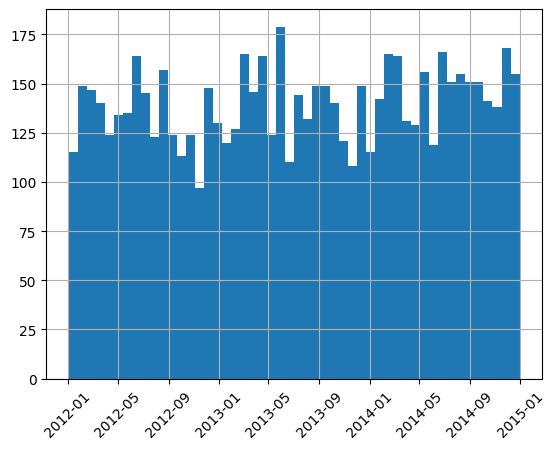

In [37]:
hy_vee_des_moines['Date'].hist(xrot=45, bins=50);

We can decipher a general pattern of peaks around the 4th of July, Labor Day weekend, and Thanksgiving & Christmas. There's also a noticable lull around June and October, which is interesting.

Additionally, there's a slight upward trend in the data; it seems to be slowly rising throughout this timespan.

All in all, we'll almost certainly need to account for this trend and seasonality by stationarizing our time-series data once we begin modeling. Before we get there, we have a little more EDA to do here at the store-level.

In [ ]:
hy_vee_des_moines['Pack'].value_counts()

Pack
12    5828
6     1145
3        7
10       5
1        4
24       3
48       1
4        1
Name: count, dtype: int64

I'm not sure whether this will just add some unhelpful noise or will it contribute some helpful information. For now, we'll keep it. Let's also inspect how the vendor list looks here.

In [33]:
len(hy_vee_des_moines['Vendor Name'].unique())

64

In [39]:
hy_vee_des_moines['Vendor Name'].value_counts()

Vendor Name
Jim Beam Brands                      1147
Diageo Americas                      1110
Luxco-St Louis                        769
Pernod Ricard USA/Austin Nichols      452
Bacardi U.S.A., Inc.                  425
                                     ... 
Duggan's Distillers Products Corp       1
Evaton, Inc.                            1
Surville Enterprises Corp               1
Four Roses Distillery                   1
Tanteo Tequila                          1
Name: count, Length: 64, dtype: int64

In [40]:
hvdm_vendor_counts = hy_vee_des_moines['Vendor Name'].value_counts()
hvdm__100_order_vendors = pd.DataFrame(hvdm_vendor_counts)
hvdm__100_order_vendors = hvdm__100_order_vendors[hvdm__100_order_vendors['count']>= 100]
hvdm__100_order_vendors

,count
Vendor Name,
Jim Beam Brands,1147
Diageo Americas,1110
Luxco-St Louis,769
Pernod Ricard USA/Austin Nichols,452
"Bacardi U.S.A., Inc.",425
Sazerac North America,367
Phillips Beverage Company,365
Proximo,292
"Sazerac Co., Inc.",267


In [49]:
print("Number of Vendors with at least 100 orders fulfilled:", len(hvdm__100_order_vendors))
print("Fraction of rows lost if we drop vendors with fewer than 100 orders:", 1 - sum(hvdm__100_order_vendors['count'] / len(hy_vee_des_moines)))

Number of Vendors with at least 100 orders fulfilled: 17
Fraction of rows lost if we drop vendors with fewer than 100 orders: 0.10510510510510518


So, if we drop the records pertaining to vendors with fewer orders, we lose 10.5% of the rows, but the vendor categories drop from an unwieldy 64 to a far more reasonable 17.

Ultimately, that's still a lot of rows. I think that, for now, I'll keep the vendor column as-is, but I won't use it for modeling at first. If the overall goal is to take a model that optimizes time-series predictions on inventory and then apply it to numerous other stores, keeping it limited to the time-series data, liquor categories, and counts is a good starting place on its own.

Once this project reaches that minimum viability point, then I may be able to come back and include vendor data.

With this groundwork laid down, let's move on to modeling our time-series inventory data with a SARIMA model.

## modeling

